In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.datasets import cifar10
import tensorflow.keras as K
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

In [3]:
train_ds, validation_ds, test_ds = tfds.load(
    "plant_village",
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteEVHG4U/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Number of training samples: 43442
Number of validation samples: 5431
Number of test samples: 5430


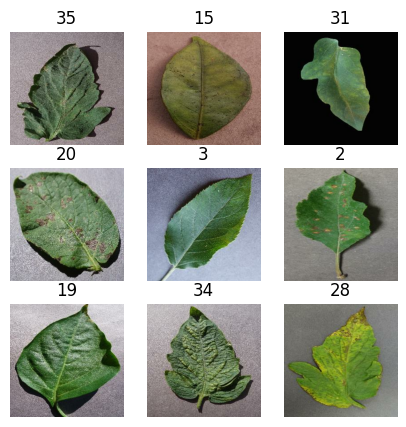

In [4]:
import matplotlib.pyplot as plt

theta = 9
p = q = 3

plt.figure(figsize=(5, 5))
for i, (image, label) in enumerate(train_ds.take(theta)):
    ax = plt.subplot(p, q, i + 1) #pq=9
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [5]:
IMG_SHAPE = 224

In [6]:
def preprocess(image, label):
    # Resize and normalize the image
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image = tf.cast(image, tf.float32) / 255.0
    
    # Convert the image to grayscale
    grayscale = tf.image.rgb_to_grayscale(image)
    
    # Convert the grayscale image to RGB
    grayscale_rgb = tf.image.grayscale_to_rgb(grayscale)
    
    return grayscale_rgb, image

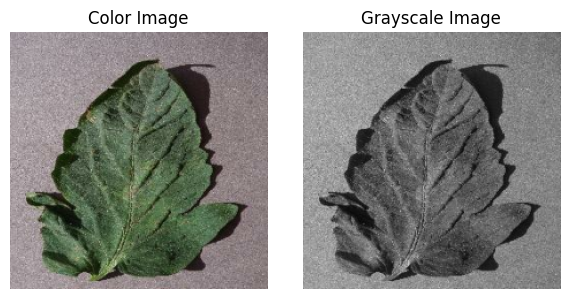

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

for image, label in train_ds.take(1):
    grayscale_image, color_image = preprocess(image, label)
    color_image = color_image.numpy()
    grayscale_image = grayscale_image.numpy()

    # Plot color image
    axes[0].imshow(color_image)
    axes[0].set_title("Color Image")
    axes[0].axis("off")
    
    # Plot grayscale image
    axes[1].imshow(grayscale_image.squeeze(), cmap="gray")
    axes[1].set_title("Grayscale Image")
    axes[1].axis("off")
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess)
validation_ds = validation_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

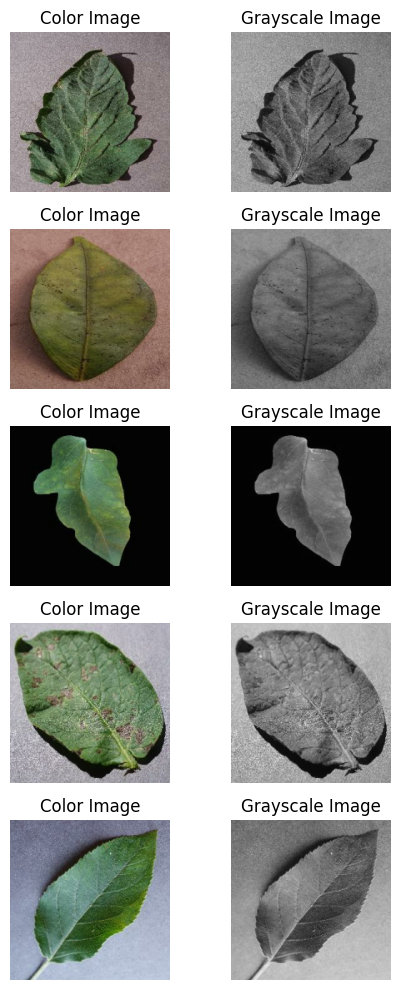

In [9]:
# Create a grid for displaying images
fig, axes = plt.subplots(5, 2, figsize=(5, 10))

for i, (grayscale_image, color_image) in enumerate(train_ds.take(5)):
    color_image = color_image.numpy()
    grayscale_image = grayscale_image.numpy()

    # Plot color image
    axes[i, 0].imshow(color_image)
    axes[i, 0].set_title("Color Image")
    axes[i, 0].axis("off")
    
    # Plot grayscale image
    axes[i, 1].imshow(grayscale_image.squeeze(), cmap="gray")
    axes[i, 1].set_title("Grayscale Image")
    axes[i, 1].axis("off")
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Define the autoencoder architecture
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        ])
        # self.encoder = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        self.decoder = tf.keras.Sequential([
            # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            # tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
# Create an instance of the autoencoder model
autoencoder = Autoencoder()

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
history = autoencoder.fit(train_ds.batch(32), epochs=20, validation_data=validation_ds.batch(32))

Epoch 1/20
1358/1358 [==============================] - 43s 24ms/step - loss: 0.6176 - val_loss: 0.6137
Epoch 2/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6130 - val_loss: 0.6126
Epoch 3/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6122 - val_loss: 0.6121
Epoch 4/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6117 - val_loss: 0.6117
Epoch 5/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6113 - val_loss: 0.6112
Epoch 6/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6110 - val_loss: 0.6110
Epoch 7/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6107 - val_loss: 0.6109
Epoch 8/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6105 - val_loss: 0.6106
Epoch 9/20
1358/1358 [==============================] - 32s 23ms/step - loss: 0.6104 - val_loss: 0.6105
Epoch 10/20
1358/1358 [==============================] - 32s 23m

1/1 [==============================] - 0s 305ms/step


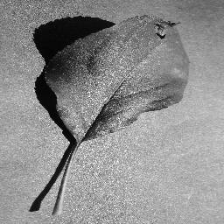

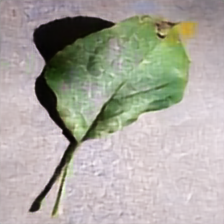

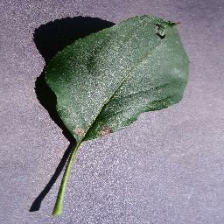

1/1 [==============================] - 0s 21ms/step


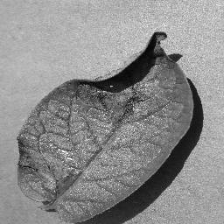

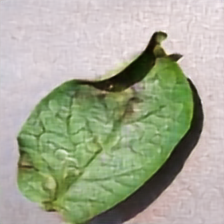

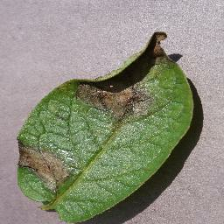

1/1 [==============================] - 0s 22ms/step


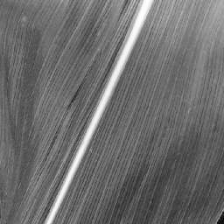

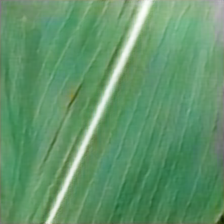

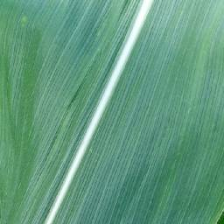

1/1 [==============================] - 0s 20ms/step


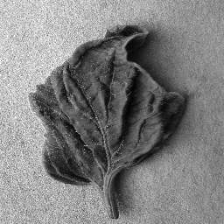

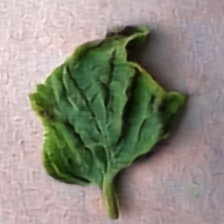

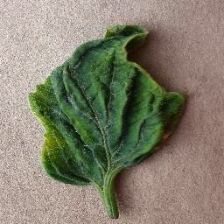

1/1 [==============================] - 0s 21ms/step


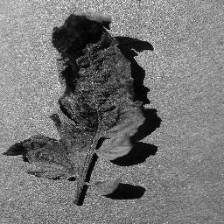

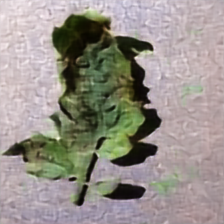

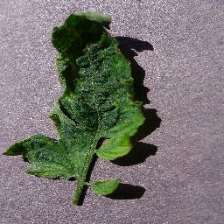

In [13]:
sample_images = test_ds.take(5)  # Take 5 images for colorization
sample_images = sample_images.batch(1)  # Set batch size to 1 for inference

for grayscale_image, og in sample_images:
    # Colorize the grayscale image
    colorized_image = autoencoder.predict(grayscale_image)
    
    # Display the original and colorized images
    tf.keras.preprocessing.image.array_to_img(grayscale_image[0]).show()
    tf.keras.preprocessing.image.array_to_img(colorized_image[0]).show()
    tf.keras.preprocessing.image.array_to_img(og[0]).show()

In [14]:
video_path = "/content/pexels-tom-fisk-3864101-3840x2160-25fps.mp4"
capture = cv2.VideoCapture(video_path)

In [15]:
frame_count = 0
frames = []

while True:
    success, frame = capture.read()
    if not success:
        break

    # Resize frame to 224x224
    frame = cv2.resize(frame, (224, 224))

    # Add frame to the list
    frames.append(frame)


In [16]:
frames = np.array(frames)
frames = frames.astype(np.float32) / 255.0 

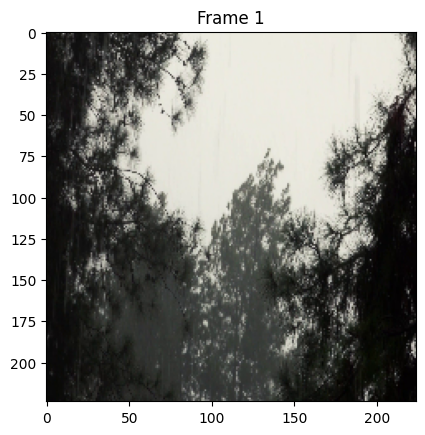

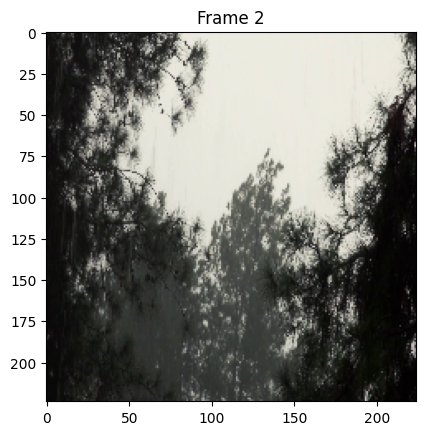

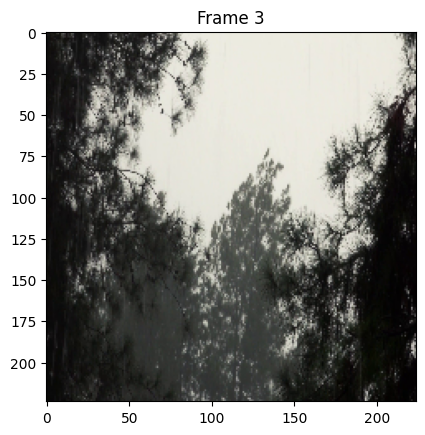

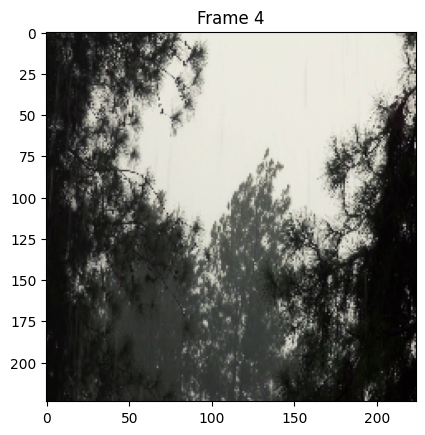

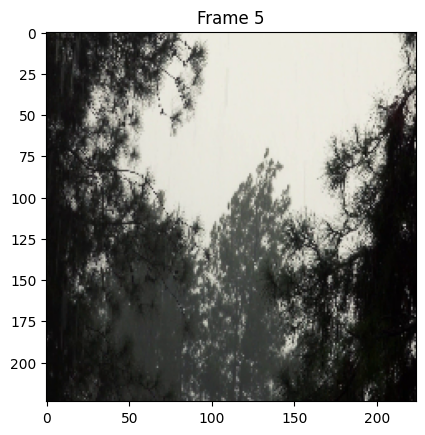

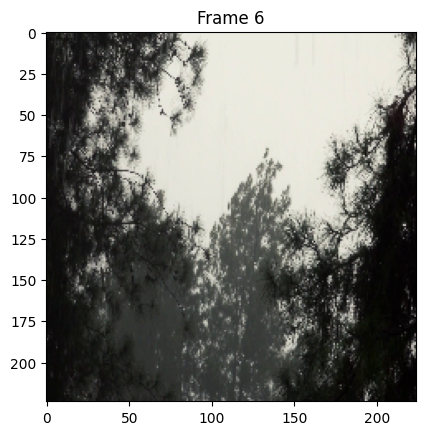

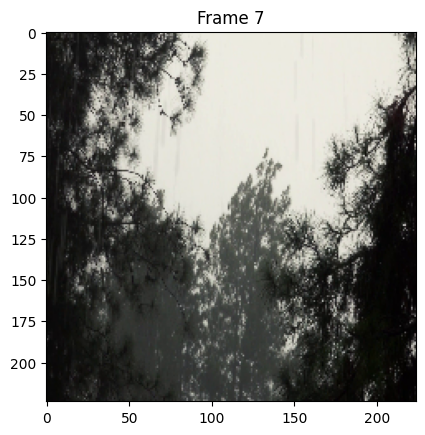

In [17]:
for i, frame in enumerate(frames):
    plt.figure()
    plt.title(f"Frame {i+1}")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    if i>5:
      break

In [18]:
predictions = autoencoder.predict(frames)

4/4 [==============================] - 0s 128ms/step


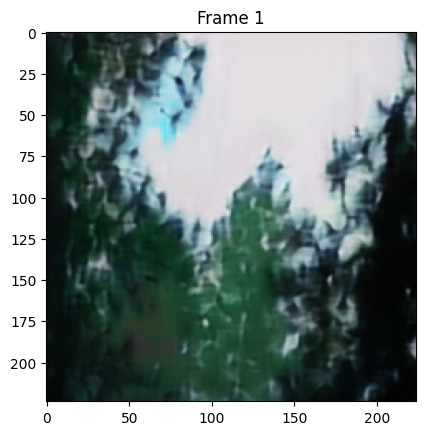

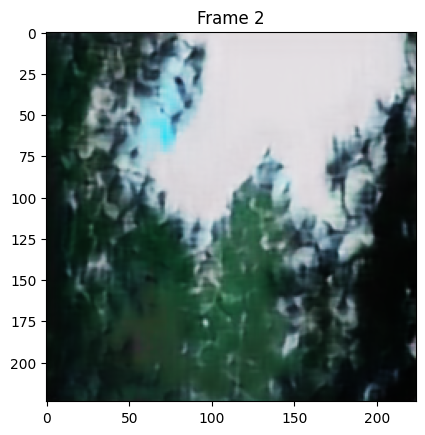

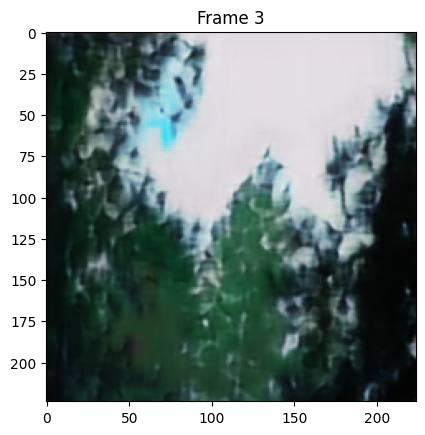

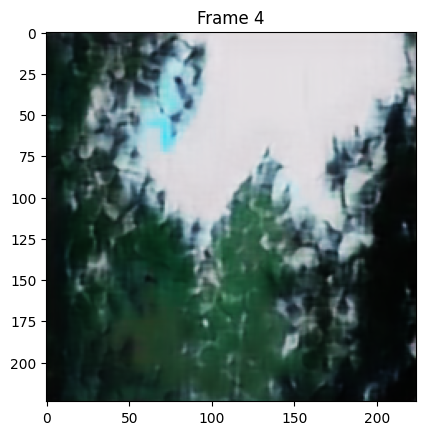

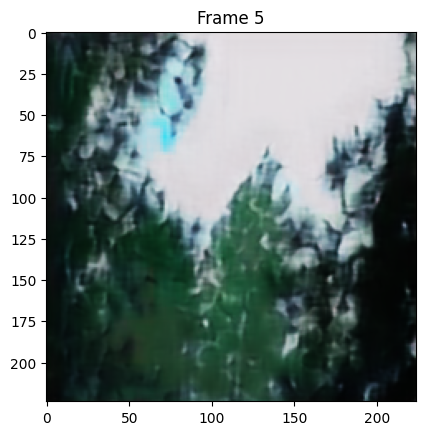

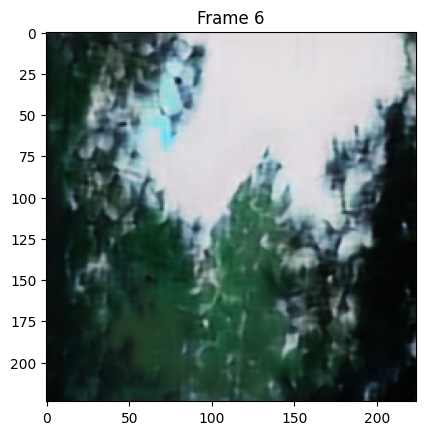

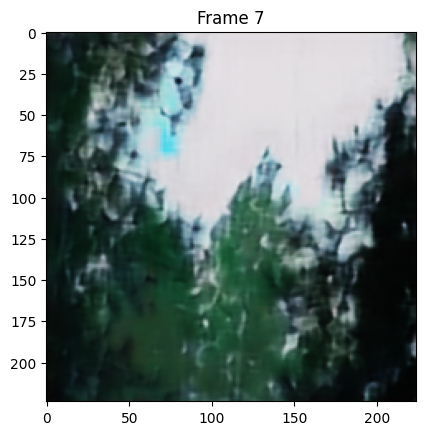

In [19]:
for i, frame in enumerate(predictions):
    plt.figure()
    plt.title(f"Frame {i+1}")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    if i>5:
      break

In [20]:
output_path = "/content/output.mp4"
# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = None

# Write each frame to the output video file
for frame in predictions:
    # Convert frame to 8-bit unsigned integer
    frame = cv2.convertScaleAbs(frame, alpha=(255.0))

    # If the video writer hasn't been initialized, create it with the first frame's dimensions
    if video_writer is None:
        frame_height, frame_width, _ = frame.shape
        video_writer = cv2.VideoWriter(output_path, fourcc, 30.0, (frame_width, frame_height))

    # Write frame to video file
    video_writer.write(frame)

# Release the VideoWriter object
if video_writer is not None:
    video_writer.release()